<a href="https://colab.research.google.com/github/MarinaOrzechowski/CNN-on-Quick-Draw-dataset/blob/master/train_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [94]:
from google.colab import drive
drive.mount('/content/gdrive')

import os
import time
import numpy as np
import pickle
import tensorflow as tf
from sklearn.model_selection import train_test_split
from __future__ import absolute_import, division, print_function, unicode_literals
from keras import datasets
from keras import models
from keras import layers
from keras.utils import to_categorical
import tensorflow_probability as tfp

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
def loadFromPickle():
    with open("/content/gdrive/My Drive/CTPproject/Pickles/imagesTest", "rb") as f:
        images = np.array(pickle.load(f))
    with open("/content/gdrive/My Drive/CTPproject/Pickles/labelsTest", "rb") as f:
        labels = np.array(pickle.load(f))

    return images, labels

##Load data from pickle files and divide into training and testing groups

In [0]:

num_of_categories = 10
images, labels = loadFromPickle()
train_images, test_images, train_labels, test_labels = train_test_split(images, labels, random_state=115,
                                                    test_size=0.3)

In [102]:
files = os.listdir("/content/gdrive/My Drive/CTPproject/data")
labels_words = [name[:-4] for name in files[:num_of_categories]]
print(labels_words)

['airplane', 'alarm clock', 'angel', 'ambulance', 'ant', 'apple', 'arm', 'asparagus', 'axe', 'backpack']


## Examine the training and testing data




In [12]:
print('shape of train images:',train_images.shape)
print('shape of test images:',test_images.shape)
print('shape of train labels:', train_labels.shape)
print('shape of testlabels:', test_labels.shape)

shape of train images: (70000, 28, 28)
shape of test images: (30000, 28, 28)
shape of train labels: (70000,)
shape of testlabels: (30000,)


## Save test images in their current form for later, since the original images will be transformed

In [0]:
saved_test_images = test_images

##Just to make sure that everything loaded correctly show the first 10 images of each category in the training data

---



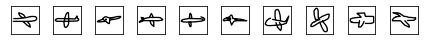

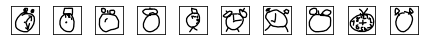

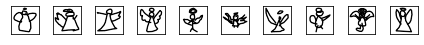

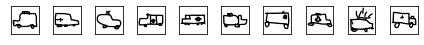

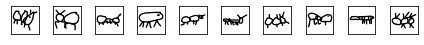

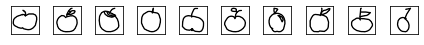

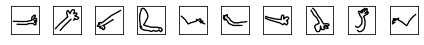

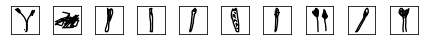

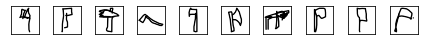

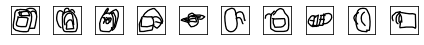

In [14]:
for k in range(num_of_categories):
  fig, ax = plt.subplots(nrows=1, ncols=10, sharex=True, sharey=True)
  ax = ax.flatten()
  for i in range(10):
      img = train_images[train_labels == k][i].reshape(28, 28)
      ax[i].imshow(img, cmap='Greys', interpolation='nearest')
  ax[0].set_xticks([])
  ax[0].set_yticks([])
  plt.tight_layout()
  plt.show()

#Display an image in more detail.
We used reversed gray scale where ligehter pixels are closer to 0, and darker are closer to 1.

[]

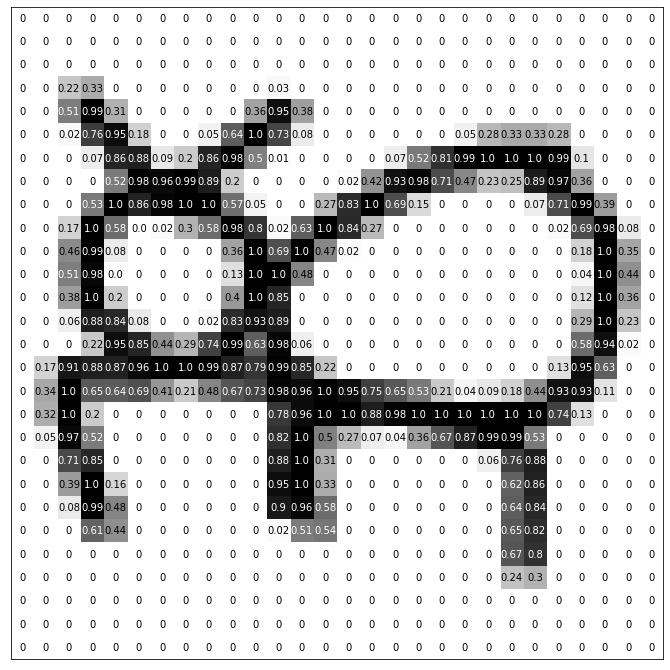

In [15]:
image = train_images[2]
image.shape

fig = plt.figure(figsize = (12, 12))
ax = fig.add_subplot(111)
ax.imshow(image, cmap = 'gray_r')
width, height = image.shape
thresh = image.max()/2 # use for color of text in pixels annotations
for x in range(width):
  for y in range(height):
    val = round(image[x][y],2) if image[x][y] != 0 else 0
    ax.annotate(str(val), xy=(y,x),
                horizontalalignment = 'center',
                verticalalignment = 'center',
                color = 'white' if image[x][y] > thresh else 'black')
ax.set_xticks([])
ax.set_yticks([])    

#**Define the network architecture.** 
We will define several models changing the model pooling method, and overlapping/non-overlapping pooling windows (for school project).

In all the models we will use **Adam** model optimizer, as it seems to be faster than most of other oprimizers according to https://towardsdatascience.com/the-3-best-optimization-methods-in-neural-networks-40879c887873.



In [0]:
def build_model_maxpooling(poolsize, stride):
  model = models.Sequential()
  model.add(layers.Conv2D(32, (5, 5),
                            activation='relu', 
                            input_shape=(28, 28, 1)))
  
  model.add(layers.MaxPooling2D(pool_size=poolsize, strides=stride))
  model.add(layers.Dropout(0.2)) #to avoid overfitting

  model.add(layers.Conv2D(64, (5, 5),
                            activation='relu'))
  model.add(layers.MaxPooling2D(pool_size=poolsize, strides=stride))
  model.add(layers.Dropout(0.2)) 


  model.add(layers.Flatten()) 
  model.add(layers.Dense(1024, 
                          activation='relu'))
  model.add(layers.Dense(10,
                            activation='softmax')) #convert scores into probabilities that the image depicts its corresponding image class
  model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy','categorical_crossentropy'])
  return model


In [17]:
batch_size = 128 # number of training images which will be seeing in 
                 # one training iteration (one time when the network makes a mistake
                 # and learns from it using backpropagation)
epochs = 10
print ('using convolutional net architecture with batch size of ',batch_size)

using convolutional net architecture with batch size of  128


#**2 hidden layers**

In [25]:
model_max_stride2 = build_model_maxpooling((2,2),(2,2))
model_max_stride2.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 24, 24, 32)        832       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 12, 12, 32)        0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 8, 8, 64)          51264     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 4, 4, 64)          0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 4, 4, 64)          0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 1024)             

#Prepare the image data

In [26]:
train_images = train_images.reshape((train_images.shape[0], 28, 28, 1))
test_images = test_images.reshape((test_images.shape[0], 28, 28, 1))

print ('shape of training images:', train_images.shape)
print ('shape of test images:', test_images.shape)

shape of training images: (70000, 28, 28, 1)
shape of test images: (30000, 28, 28, 1)


# Prepare the label data. Change from categorical labels to one-hot-encoded labels

In [27]:
j=3
print ('categorical label:',train_labels[j])
train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

print ('one-hot label:',train_labels[j])

categorical label: 7
one-hot label: [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


# Train the network

In [32]:
start = time.time()
history=model_max_stride2.fit(train_images,
            train_labels,
            epochs=epochs,
            batch_size=batch_size,
            validation_data=(test_images,test_labels))
end = time.time()
training_time = end-start;

Train on 70000 samples, validate on 30000 samples
Epoch 1/10
70000/70000 [==============================] - 88s 1ms/step - loss: 0.5942 - accuracy: 0.8180 - categorical_crossentropy: 0.5942 - val_loss: 0.3538 - val_accuracy: 0.8971 - val_categorical_crossentropy: 0.3538
Epoch 2/10
70000/70000 [==============================] - 87s 1ms/step - loss: 0.3418 - accuracy: 0.8994 - categorical_crossentropy: 0.3418 - val_loss: 0.2795 - val_accuracy: 0.9193 - val_categorical_crossentropy: 0.2795
Epoch 3/10
70000/70000 [==============================] - 91s 1ms/step - loss: 0.2834 - accuracy: 0.9160 - categorical_crossentropy: 0.2834 - val_loss: 0.2618 - val_accuracy: 0.9227 - val_categorical_crossentropy: 0.2618
Epoch 4/10
70000/70000 [==============================] - 87s 1ms/step - loss: 0.2434 - accuracy: 0.9271 - categorical_crossentropy: 0.2434 - val_loss: 0.2393 - val_accuracy: 0.9289 - val_categorical_crossentropy: 0.2393
Epoch 5/10
70000/70000 [==============================] - 88s 1ms/

In [55]:
print('\nhistory dict:', history.history)


history dict: {'val_loss': [0.35382265470822655, 0.2794506933927536, 0.2617900463422139, 0.23925174560546875, 0.2360855297724406, 0.22701952579021453, 0.22755694936116536, 0.23088935388724008, 0.23624616486231487, 0.25242762613693875], 'val_accuracy': [0.8970666527748108, 0.9192666411399841, 0.9226666688919067, 0.9288666844367981, 0.9312000274658203, 0.9338666796684265, 0.9350000023841858, 0.9357333183288574, 0.9355999827384949, 0.9338666796684265], 'val_categorical_crossentropy': [0.35382264852523804, 0.2794507145881653, 0.26179009675979614, 0.2392517775297165, 0.23608553409576416, 0.22701957821846008, 0.2275569885969162, 0.23088940978050232, 0.23624619841575623, 0.25242769718170166], 'loss': [0.5941631197043827, 0.34183333828108653, 0.2834308135168893, 0.24341875797680446, 0.2154455672434398, 0.18575380867549351, 0.1632738169022969, 0.14066780380180904, 0.12258132050037385, 0.10485652046033314], 'accuracy': [0.8179714, 0.89935714, 0.91597146, 0.9271, 0.9338143, 0.9419857, 0.9482, 0.

#Plot the loss

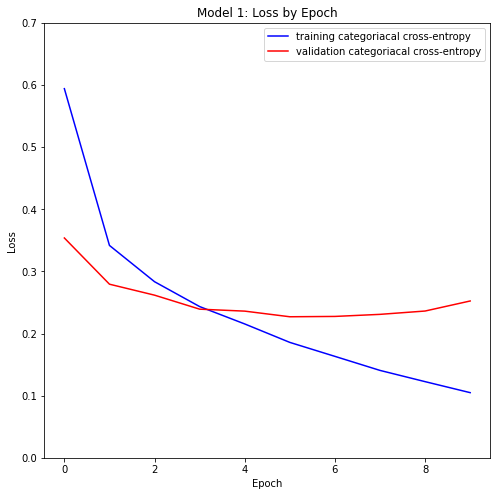

In [56]:
def plot_loss(history):
  plt.figure(figsize=(8,8))
  plt.plot(history.history['loss'], label='training categoriacal cross-entropy', color='blue')
  plt.plot(history.history['val_loss'], label='validation categoriacal cross-entropy', color='red')
  plt.title('Model 1: Loss by Epoch')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.ylim([0.0, .7])
  plt.legend(loc='upper right')

plot_loss(history)

#Plot accuracy

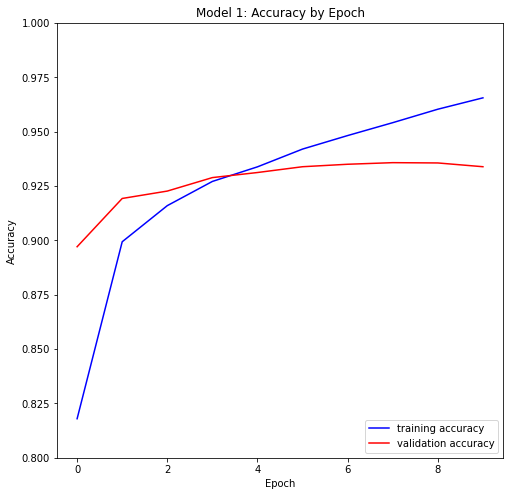

In [57]:
# plot the accuracy
def plot_accuracy(history):
  plt.figure(figsize=(8,8))
  plt.plot(history.history['accuracy'], label='training accuracy',color='blue')
  plt.plot(history.history['val_accuracy'], label = 'validation accuracy',color='red')
  plt.title('Model 1: Accuracy by Epoch')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.ylim([0.8, 1.00])
  plt.legend(loc='lower right')
  
plot_accuracy(history)

# Apply the model to the testing data


In [58]:
test_evaluation1 = model_max_stride2.evaluate(test_images, test_labels)
test_loss1 = test_evaluation[0]
test_acc1 = test_evaluation[1]

print ('test loss: ',test_loss)
print ('test acc:  ', test_acc)
print ('errors:  ', int(10000*(1-test_acc)))

30000/30000 [==============================] - 11s 360us/step
test loss:  0.252427631330428
test acc:   0.9338666796684265
errors:   661


Test accuracy is only 93.39% which is good, but still gave us 661 errors out of 30000 tested images. 

Lets try to improve this result by adding extra hidden layer.

#**3 hidden layers**

In [0]:
def build_model_maxpooling(poolsize, stride):
  model = models.Sequential()
  model.add(layers.Conv2D(32, (5, 5),
                            activation='relu', 
                            input_shape=(28, 28, 1)))
  
  model.add(layers.MaxPooling2D(pool_size=poolsize, strides=stride))
  model.add(layers.Dropout(0.2)) #to avoid overfitting

  model.add(layers.Conv2D(64, (5, 5),
                            activation='relu'))
  model.add(layers.MaxPooling2D(pool_size=poolsize, strides=stride))
  model.add(layers.Dropout(0.2)) 

  model.add(layers.Conv2D(128, (5, 5),
                            activation='relu', padding = 'same'))
  model.add(layers.MaxPooling2D(pool_size=poolsize, strides=stride))

  model.add(layers.Flatten()) 
  model.add(layers.Dense(1024, 
                          activation='relu'))
  model.add(layers.Dense(10,
                            activation='softmax')) #convert scores into probabilities that the image depicts its corresponding image class
  model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy','categorical_crossentropy'])
  return model

In [68]:
model_max_stride2_3hl = build_model_maxpooling((2,2),(2,2))
model_max_stride2_3hl.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_43 (Conv2D)           (None, 24, 24, 32)        832       
_________________________________________________________________
max_pooling2d_37 (MaxPooling (None, 12, 12, 32)        0         
_________________________________________________________________
dropout_30 (Dropout)         (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 8, 8, 64)          51264     
_________________________________________________________________
max_pooling2d_38 (MaxPooling (None, 4, 4, 64)          0         
_________________________________________________________________
dropout_31 (Dropout)         (None, 4, 4, 64)          0         
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 4, 4, 128)       

In [69]:
start = time.time()
history2=model_max_stride2_3hl.fit(train_images,
            train_labels,
            epochs=epochs,
            batch_size=batch_size,
            validation_data=(test_images,test_labels))
end = time.time()
training_time2 = end-start;

Train on 70000 samples, validate on 30000 samples
Epoch 1/10
70000/70000 [==============================] - 141s 2ms/step - loss: 0.6225 - accuracy: 0.8003 - categorical_crossentropy: 0.6225 - val_loss: 0.3579 - val_accuracy: 0.8923 - val_categorical_crossentropy: 0.3579
Epoch 2/10
70000/70000 [==============================] - 140s 2ms/step - loss: 0.3327 - accuracy: 0.9002 - categorical_crossentropy: 0.3327 - val_loss: 0.2723 - val_accuracy: 0.9194 - val_categorical_crossentropy: 0.2723
Epoch 3/10
70000/70000 [==============================] - 142s 2ms/step - loss: 0.2722 - accuracy: 0.9185 - categorical_crossentropy: 0.2722 - val_loss: 0.2478 - val_accuracy: 0.9265 - val_categorical_crossentropy: 0.2478
Epoch 4/10
70000/70000 [==============================] - 139s 2ms/step - loss: 0.2359 - accuracy: 0.9271 - categorical_crossentropy: 0.2359 - val_loss: 0.2365 - val_accuracy: 0.9304 - val_categorical_crossentropy: 0.2365
Epoch 5/10
70000/70000 [==============================] - 139s

In [71]:
print('\nhistory dict:', history2.history)


history dict: {'val_loss': [0.35785591740608214, 0.2722657642920812, 0.2478422645409902, 0.2365134930531184, 0.22175440487861633, 0.222699409087499, 0.22492992303371429, 0.23300975277423858, 0.25099398718674976, 0.23737542439699172], 'val_accuracy': [0.8923333287239075, 0.9193999767303467, 0.9265333414077759, 0.9303666949272156, 0.9345666766166687, 0.934066653251648, 0.9347333312034607, 0.935366690158844, 0.9307000041007996, 0.9352666735649109], 'val_categorical_crossentropy': [0.3578559458255768, 0.2722657024860382, 0.24784228205680847, 0.23651345074176788, 0.22175434231758118, 0.2226993590593338, 0.22492989897727966, 0.2330097109079361, 0.2509939968585968, 0.2373754382133484], 'loss': [0.6224563183375768, 0.3326711623532431, 0.27221088961873735, 0.23594865198816573, 0.2104298664229257, 0.19004380869865417, 0.1693406273160662, 0.15338417337111065, 0.13696222791501453, 0.1272097719158445], 'accuracy': [0.80032855, 0.9001714, 0.9185143, 0.92705715, 0.9362, 0.9412, 0.9466571, 0.95084286

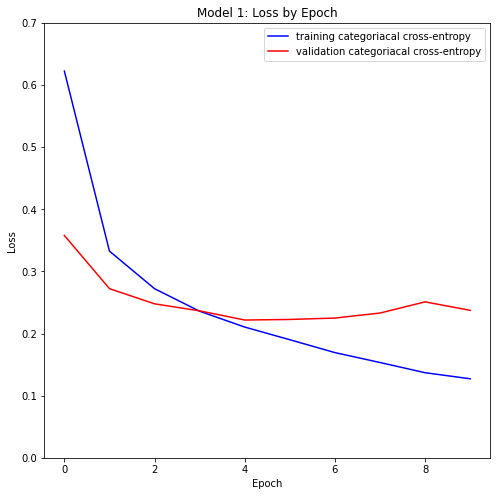

In [72]:
plot_loss(history2)

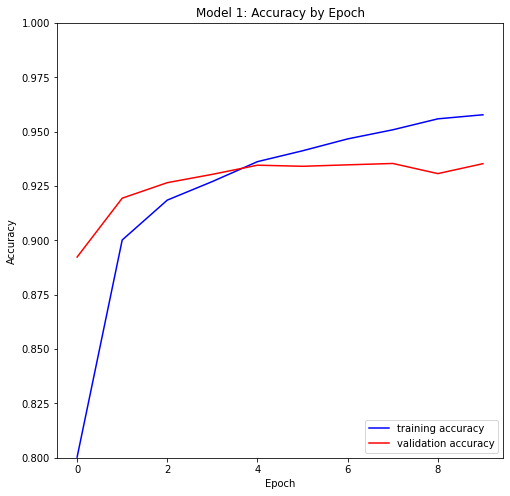

In [73]:
plot_accuracy(history2)

# Apply the model to the testing data


In [75]:
test_evaluation2 = model_max_stride2_3hl.evaluate(test_images, test_labels)
test_loss2 = test_evaluation[0]
test_acc2 = test_evaluation[1]

print ('test loss: ',test_loss2)
print ('test acc:  ', test_acc2)
print ('errors:  ', int(10000*(1-test_acc2)))

30000/30000 [==============================] - 13s 433us/step
test loss:  0.252427631330428
test acc:   0.9338666796684265
errors:   661


# get the categories for all test cases

In [83]:
pred_test_labels = model_max_stride2_3hl.predict(test_images)

# convert the one-hot encoding values to a category
test_cat = np.argmax(test_labels,axis=-1)
pred_test_cat = np.argmax(pred_test_labels,axis=-1)

print ('\nshape of pred_test_labels:',pred_test_labels.shape)
print ('shape of test_labels:     ',pred_test_labels.shape)
print ('shape of test_cat:        ',test_cat.shape)
print ('shape of pred_test_cat:   ',pred_test_cat.shape)


shape of pred_test_labels: (30000, 10)
shape of test_labels:      (30000, 10)
shape of test_cat:         (30000,)
shape of pred_test_cat:    (30000,)


In [84]:
correct_lab = test_cat[test_cat != pred_test_cat]
incorrect_lab = pred_test_cat[test_cat != pred_test_cat]
incorrect_image = saved_test_images[test_cat != pred_test_cat]
p_label = pred_test_labels[test_cat != pred_test_cat,:]
t_label = test_labels[test_cat != pred_test_cat,:]

print ('\nerrors:',len(incorrect_lab))
print ('\nshape of correct_lab:    ',incorrect_lab.shape)
print ('shape of incorrect_lab:  ',incorrect_lab.shape)
print ('shape of incorrect_image:',incorrect_image.shape)
print ('shape of p_label:        ',p_label.shape)
print ('shape of t_label:        ',t_label.shape)


errors: 1942

shape of correct_lab:     (1942,)
shape of incorrect_lab:   (1942,)
shape of incorrect_image: (1942, 28, 28)
shape of p_label:         (1942, 10)
shape of t_label:         (1942, 10)


# look at some misclassifications


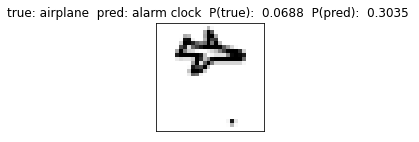

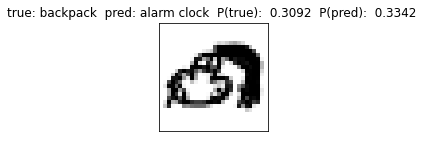

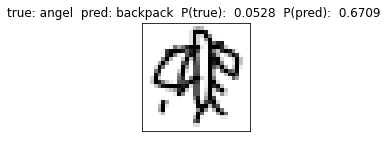

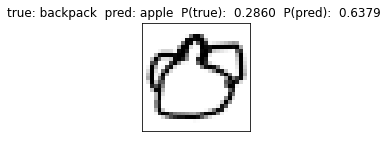

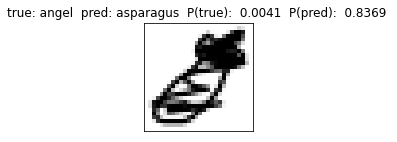

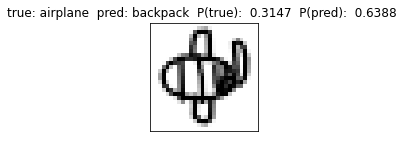

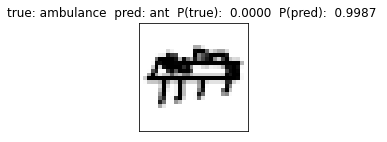

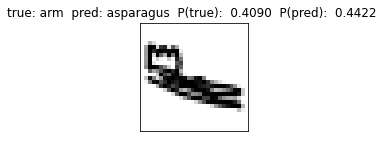

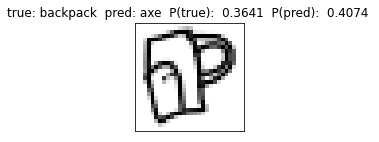

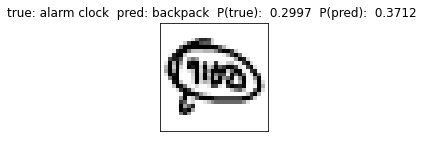

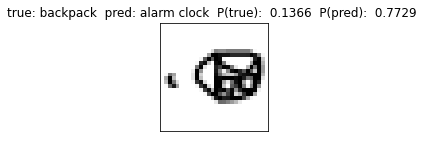

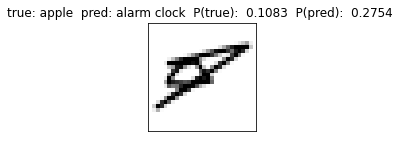

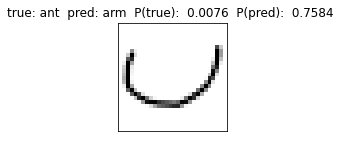

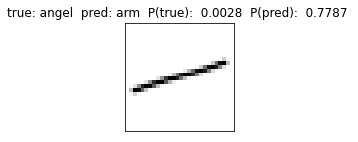

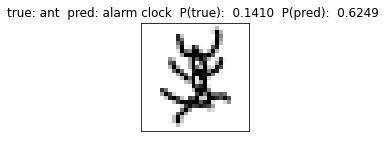

In [103]:

number_of_cases = 15
for i in range(min(number_of_cases,len(correct_lab))):
    img = incorrect_image[i].reshape(28,28)
    plt.figure(figsize=(2,2))
    plt.imshow(img, cmap='Greys', interpolation='nearest')
    plt.title('true: %s  pred: %s  P(true): %7.4f  P(pred): %7.4f ' % (labels_words[correct_lab[i]], labels_words[incorrect_lab[i]],p_label[i,correct_lab[i]],p_label[i,incorrect_lab[i]]))
    plt.xticks([])
    plt.yticks([])
    plt.show() 

We can see that these images are not great examples of their categories


# get heatmap of true vs predicted categories for all test data



misclasifications for each categoryt
[1069.5 1082.5 1082.5 1035.5 1037.  1027.  1104.  1046.5 1112.  1058.5]


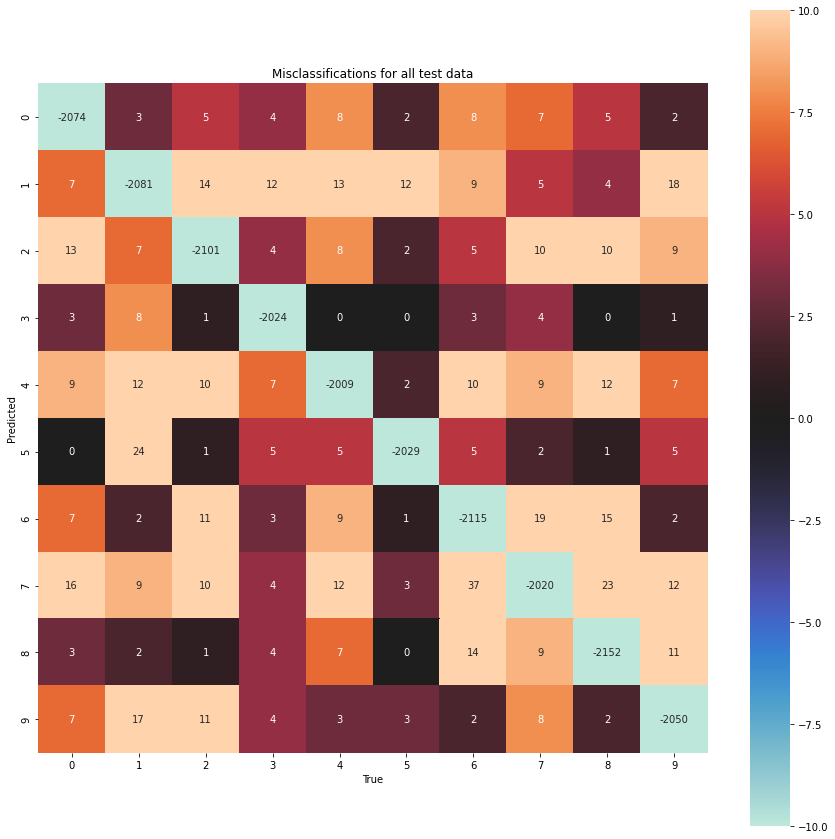

In [105]:
dist_test = np.zeros(10)
for j in range(len(test_labels)):
  dist_test[test_labels[j].astype('int16')] += 1

hmap= np.zeros((10,10))
for k in range(10000):
  hmap[pred_test_cat[k],test_cat[k]] += 1
for i in range(10):
  hmap[i,i] -= dist_test[i]  

# find number of misclasifications by true value
mis_classifications = np.zeros(10)
for j in range(10):
  for i in range(10):
    mis_classifications[j] += abs(hmap[i,j])/2
print ('\nmisclasifications for each categoryt')
print (mis_classifications)  

plt.figure(figsize=(15,15))
sns.heatmap(hmap, annot=True,fmt='.4g',vmin=-10, vmax=10, center= 0, square=True)
plt.title('Misclassifications for all test data')
plt.xlabel('True')
plt.ylabel('Predicted')
plt.show()